In [2]:
import numpy as np
from scipy import stats,signal
import matplotlib.pyplot as plt
from scipy.optimize import minimize

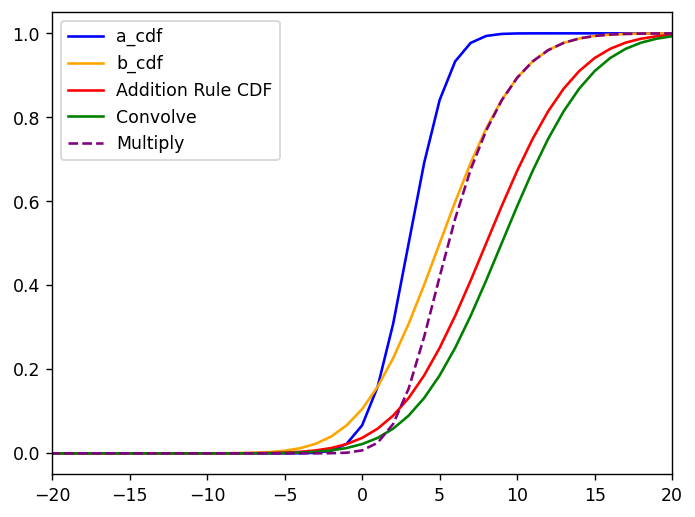

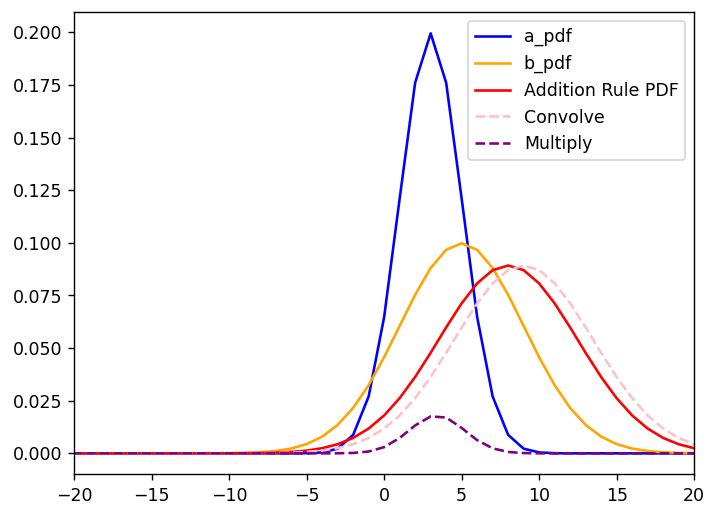

In [3]:
dx = 1
x = np.arange(-3000,3000,dx)
mu_a,mu_b = 3,5
sd_a,sd_b = 2,4
a_cdf = stats.norm.cdf(x,loc = mu_a,scale=sd_a)
a_pdf = stats.norm.pdf(x,loc = mu_a,scale=sd_a)
b_cdf = stats.norm.cdf(x,loc=mu_b,scale = sd_b)
b_pdf = stats.norm.pdf(x,loc=mu_b,scale = sd_b)

c1_cdf = stats.norm.cdf(x,loc= mu_a + mu_b,scale = np.sqrt(sd_a**2 + sd_b**2))
c1_pdf = stats.norm.pdf(x,loc= mu_a + mu_b,scale = np.sqrt(sd_a**2 + sd_b**2))

c2_pdf = signal.fftconvolve(a_pdf,b_pdf, mode = 'same')*dx
c2_cdf = signal.fftconvolve(a_cdf,b_pdf,mode='same')*dx

c3_pdf = a_pdf*b_pdf
c3_cdf = a_cdf*b_cdf

fig,ax = plt.subplots(dpi=125)
ax.plot(x,a_cdf,c='blue',label='a_cdf')
ax.plot(x,b_cdf,c='orange',label='b_cdf')
ax.plot(x,c1_cdf, c='red',label='Addition Rule CDF')
ax.plot(x,c2_cdf, c='green',label ='Convolve')
ax.plot(x,c3_cdf,ls='--', c='purple',label='Multiply')
ax.set_xlim(-20,20)
ax.legend()
plt.show()

fig,ax = plt.subplots(dpi=125)
ax.plot(x,a_pdf,c='blue',label='a_pdf')
ax.plot(x,b_pdf,c='orange',label='b_pdf')
ax.plot(x,c1_pdf, c='red',label='Addition Rule PDF')
ax.plot(x,c2_pdf, ls='--', c='pink',label ='Convolve')
ax.plot(x,c3_pdf,ls='--', c='purple',label='Multiply')
ax.set_xlim(-20,20)
ax.legend()
plt.show()

Reaction Distribution Convolve example

In [4]:
stats.skewnorm.pdf.__doc__

'Probability density function at x of the given RV.\n\n        Parameters\n        ----------\n        x : array_like\n            quantiles\n        arg1, arg2, arg3,... : array_like\n            The shape parameter(s) for the distribution (see docstring of the\n            instance object for more information)\n        loc : array_like, optional\n            location parameter (default=0)\n        scale : array_like, optional\n            scale parameter (default=1)\n\n        Returns\n        -------\n        pdf : ndarray\n            Probability density function evaluated at x\n\n        '

1301.0000000000005 155.24174696260042 2.1136210969058306e-13 3.0000000000335807
1452.0000000000014 160.31219541881416 2.0717234842920336e-14 3.0000000000448575


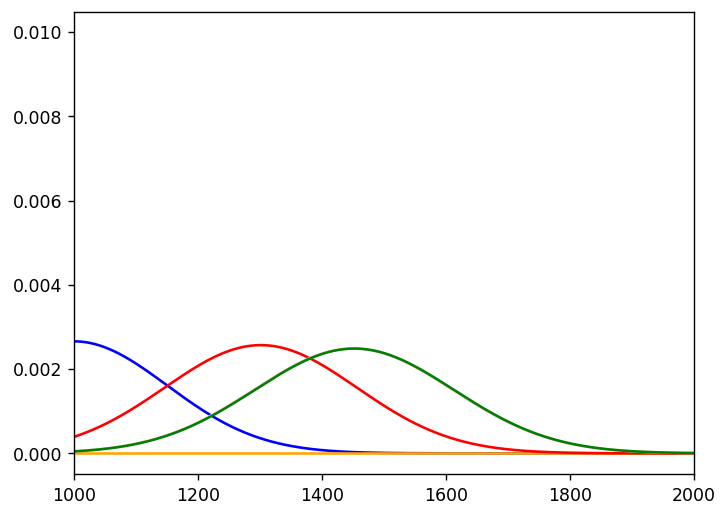

In [20]:
dx = 1
x = np.arange(-5000,5000,dx)
agent_dis = stats.skewnorm.pdf(x,0,1000,150)
reaction_dis = stats.skewnorm.pdf(x,0,300,40)
movement_dis = stats.skewnorm.pdf(x,0,150,40)

leave_pdf = signal.fftconvolve(reaction_dis,agent_dis, mode = 'same') *dx
reach_pdf = signal.fftconvolve(leave_pdf,movement_dis, mode = 'same') *dx

leave_mean = np.sum(x*leave_pdf)*dx
leave_std = np.sqrt(np.sum((x-leave_mean)**2*leave_pdf)*dx)
leave_skew = np.sum((((x-leave_mean)/leave_std)**3)*leave_pdf)*dx
leave_kurtosis = np.sum(((((x-leave_mean)/leave_std))**4)*leave_pdf)*dx

reach_mean = np.sum(x*reach_pdf)*dx
reach_std = np.sqrt(np.sum((x-reach_mean)**2*reach_pdf)*dx)
reach_skew = np.sum((((x-reach_mean)/reach_std)**3)*reach_pdf)*dx
reach_kurtosis = np.sum(((((x-reach_mean)/reach_std))**4)*reach_pdf)*dx

test_leave_dist = stats.skewnorm.pdf(x,leave_skew,leave_mean,leave_std)
test_reach_dist = stats.skewnorm.pdf(x,reach_skew,reach_mean,reach_std)

addition_test = stats.norm.pdf(x,1000+300+150,np.sqrt(150**2 + 40**2 + 40**2))
fig,ax = plt.subplots(dpi=125)

ax.plot(x,agent_dis, c= 'blue')
ax.plot(x,reaction_dis,c='orange')
ax.plot(x,leave_pdf,c='red')
ax.plot(x,addition_test,c='pink')
ax.plot(x,reach_pdf,c='green')
ax.set_xlim(1000,2000)
print(leave_mean,leave_std,leave_skew,leave_kurtosis)
print(reach_mean,reach_std,reach_skew,reach_kurtosis)

Integrate PDF

In [6]:
np.sum((((x-1000)/200))**4*agent_dis)*dx

0.9492187500000002

(-3000.0, 3000.0)

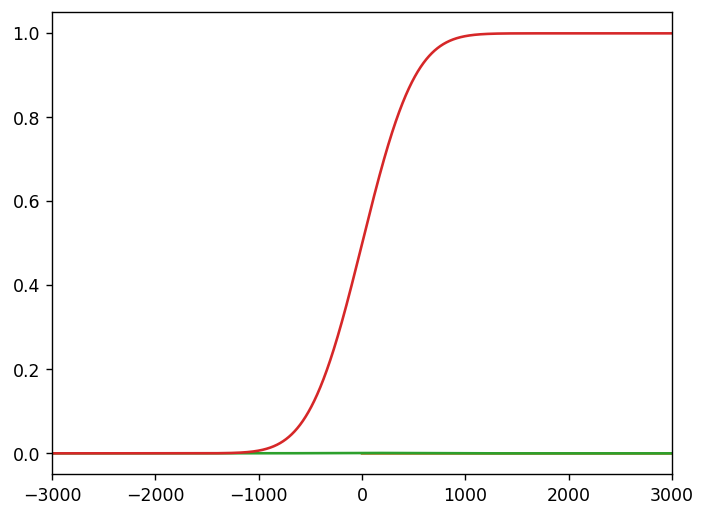

In [7]:
optimal_decision_time = 1000
timing_dis = stats.norm.pdf(x,optimal_decision_time,400)
timing_dis_neg = stats.norm.pdf(-x,optimal_decision_time,400)
timing_prob = stats.norm.cdf(x,optimal_decision_time,90)
timing_conv_subtraction_pdf = signal.fftconvolve(agent_dis,timing_dis_neg,mode='same')*dx
timing_sub_check = stats.norm.pdf(x,optimal_decision_time-1000,np.sqrt(400**2 + 50**2))
timing_sub_cdf = stats.norm.cdf(x,1000-1000,np.sqrt(400**2 + 50**2))

fig,ax = plt.subplots(dpi=125)

ax.plot(timing_dis_neg)
ax.plot(agent_dis)
ax.plot(x,timing_sub_check)
ax.plot(x,timing_sub_cdf)
ax.set_xlim(-3000,3000)

Convolution with truncated norm

In [8]:
# Create truncated norm based on optimal decision time 


In [9]:
len(timing_sub_cdf)

10000

In [10]:
timing_sub_cdf[3000 + 80]

9.539922057689586e-07

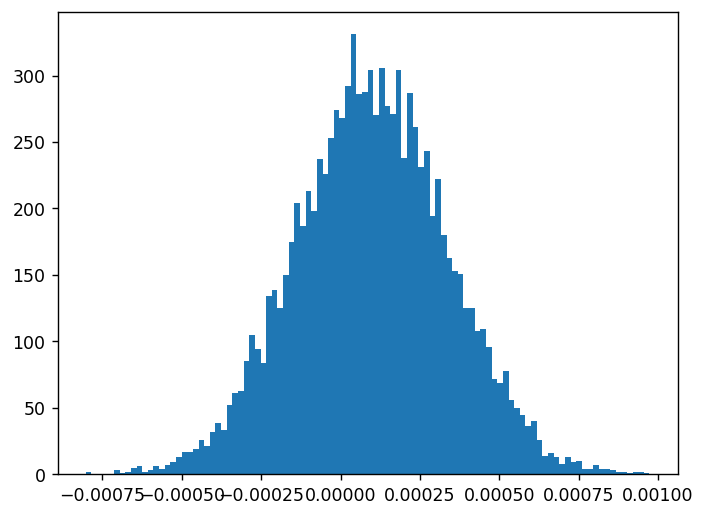

In [11]:
mu,std = stats.norm.fit(data=timing_conv_subtraction_pdf)
y = stats.norm.rvs(mu,std,len(x))
fig,ax = plt.subplots(dpi=125)
ax.hist(y,bins=100)
plt.show()

In [12]:
std

0.00024248035534668035

In [13]:
def mse_fit(params):
    mean = params[0]   
    sd = params[1]
    estimated_pdfs = stats.norm.pdf(x, loc=mean, scale=sd)
    mse = ((estimated_pdfs - timing_conv_subtraction_pdf)**2).mean()

    return mse

initParams = [1, 1]

results = minimize(mse_fit, initParams, method='Nelder-Mead')
print(results.x)


[119.58225992 410.00719706]
